#cambio y aplicar cambios en VM

# Título  gbtd con envío
## Autor: Jose Chelquer
## Fecha de última modificación: 21/11/2024

Hace lightbt y envía en base a parametros optimizados



## Parámetros

< Descripción de cada uno de los parámetros que utiliza el job >


In [4]:
experimento='competencia_sample'
# Con qué dataset trabajar
# "": sin variables rf
# "rf": con variables rf
dset="rf"               # usado para tener dos juegos de datos
#dset=""
feat="aum"              # usado para tener aumentadas y no
#feat=""

In [5]:
# vm o local?
vm=True
if vm:
  usar_gdrive=False
else:
  usar_gdrive=True      #se va a usar google dirve


In [6]:
semillas=[101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197]

ganancia_acierto=273000
costo_estimulo=7000

In [7]:
# meses de entrenamiento, evaluación y test
if vm:
  mes_train_desde = 202101
  mes_train_hasta = 202105
  mes_eval=202106
  mes_test = 202108
else:
  mes_train_desde = 202104
  mes_train_hasta = 202105
  mes_eval=202106
  mes_test = 202108

In [8]:

params_fijos={
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31
    
}
lgb_verbosity=-1
num_boost_round= 500

In [9]:
params_file="best_params.json"

In [10]:

grabar_importancias=False          # Se puede pedir que grabe las importancias de variables como resultado secundario
importancias_file=f'importancias_lgb{experimento}.csv.gz'


In [11]:
# parámetros de envío a kaggle
version = f'202_{experimento}_'
prefijo_envio=f"j010_lgb_{experimento}_"
enviar_desde=7000
enviar_hasta=16000
cant_envios=10            #Cantidad de envíos a Kaggle


## Input

< Archivos de datos (csv.gz) con sus paths que van a consumirse por el job>

In [12]:
# EL script se adapta a archivos .csv o .csv.gz
if vm:
  dataset_path = '/home/jose/buckets/b1/datasets'
  kaggle_json_path="/home/jose/buckets/b1"
  if dset=="rf":
    if feat=="aum":
        dataset_file='k2_aumentada_conRF.parquet.gz'
    else:
        dataset_file='competencia_02_conRF.parquet.gz'

  else:
    if feat=="aum":
        dataset_file='competencia_02_aumentada.parquet.gz'
    else:
        dataset_file='competencia_02.parquet.gz'

else:
  dataset_path='/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas/dmeyf/dmeyf2024/datasets/'
  kaggle_json_path="/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas"

  sufijo=''
  if dset=="rf":
    sufijo='_cRF'
  infijo='_base'
  if feat=="aum":
    infijo='_aum'

  dataset_file=f"sample_c02{infijo}_m1a8{sufijo}.csv.gz"

print (dataset_file)

k2_aumentada_conRF.parquet.gz


## Output

< Archivos, bases de datos, modelos que va a generar el job>

In [13]:

if vm:
  db_path='/home/jose/buckets/b1/db'
  modelos_path='/home/jose/buckets/b1/modelos'

else:
  db_path='/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas/dmeyf/dmeyf2024/db/'
        # optuna no puede hacerlo en drive.  La copia se hará al final, si se puede
  modelos_path='/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas/dmeyf/dmeyf2024/modelos/'

modelos_file=f'lgb_optimizado_{experimento}'

## Procesos

### Paquetes necesarios

## Código del proceso

< Todo el código a partir de aquí debe poder ejecutarse sin necesidad de parametrizar nada>

Instalamos, cargamos y seteamos el entorno

## Gdrive?

In [14]:
if usar_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')

## Librerías

In [15]:
!pip install --upgrade pip
!pip install --upgrade lightgbm
!pip install dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.


In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import shutil

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


import json

from time import time

import pickle



Matplotlib is building the font cache; this may take a moment.


In [17]:
import lightgbm as lgb

## Funciones útiles varias

In [18]:
def buscar_columnas(data, texto):
    # devuelve los nombre de cols de data que contengan texto
    # Encuentra las columnas que contienen el texto
    columnas_filtradas = [col for col in data.columns if texto in col]
    
    # Imprime las columnas que coinciden
    return columnas_filtradas

## Leer datos

In [19]:
semilla=semillas[2]


In [20]:
def contabilizar(df, descripción):
  print (f'\nContabilización de la base {descripción}\n')
  print (f'\nShape: {df.shape}\n')
  n_vars=len(df.columns)
  n_vars_tree=len([col for col in df.columns if col.startswith('tree')])
  print (f"Variables: {n_vars}")
  print (f"Variables tree: {n_vars_tree}")
  print (f"\nFilas por mes: \n{df['foto_mes'].value_counts()}\n")
  if 'clase_ternaria' in df.columns:
    print (f"\nFilas por mes y clase: \n{pd.crosstab(df['foto_mes'], df['clase_ternaria'])}\n")
def cant_meses(df):
  return len(df['foto_mes'].unique())

In [21]:
data = pd.read_parquet(os.path.join(dataset_path, dataset_file))
if 'clase_ternaria_num' in data.columns:
  data = data.drop(columns=['clase_ternaria_num'])

In [26]:
data = data.sort_values(by=['foto_mes', 'numero_de_cliente'])


KeyError: False

In [29]:
data.loc[data['foto_mes']==202108, 'numero_de_cliente'].head(10)

336107    249221109
41198     249221468
290249    249223005
113276    249228180
171604    249232117
320450    249236712
45703     249236857
290250    249237079
45704     249237446
148911    249239632
Name: numero_de_cliente, dtype: int64

In [30]:

contabilizar(data, 'Datos Leídos '+ dataset_file)


Contabilización de la base Datos Leídos k2_aumentada_conRF.parquet.gz


Shape: (375309, 1403)

Variables: 1403
Variables tree: 320

Filas por mes: 
foto_mes
202108    165442
202104     18363
202105     18352
202106     18271
202103     18169
202102     17886
202101     17481
202012     17307
202011     17097
202010     16921
202009     16771
202007     16629
202008     16620
Name: count, dtype: int64


Filas por mes y clase: 
clase_ternaria  BAJA+1  BAJA+2  CONTINUA
foto_mes                                
202007             627     542     15460
202008             544     472     15604
202009             474     564     15733
202010             565     488     15868
202011             490     646     15961
202012             649     634     16024
202101             635     785     16061
202102             785    1017     16084
202103            1020     981     16168
202104             982    1189     16192
202105            1189     911     16252
202106             908    1074     1

# ------------------------------------------------------------------
# Eliminado aquí a último momento para probar
# ------------------------------------------------------------------


In [31]:
columnas_comisiones = buscar_columnas(data, 'comis')
columnas_finic=buscar_columnas(data, 'finic')
columnas_avg=buscar_columnas(data, 'avg')
columnas_ratio=buscar_columnas(data, 'ratio')
columnas_tree=buscar_columnas(data, 'tree')
columnas_lag=buscar_columnas(data, 'lag')


#columnas_a_eliminar=columnas_comisiones+columnas_finic+columnas_avg
columnas_a_eliminar=(columnas_comisiones
                     )
columnas_a_eliminar=[]

data = data.drop(columns=columnas_a_eliminar)
print (f"Nueva cantidad de columnas {len(data.columns)}")

Nueva cantidad de columnas 1370


In [32]:
# FIN DEL AGREGADO DE ULTIMO MOMENTO

Vamos a asignar pesos a las clases. En unos minutos explicaremos las razones detrás de esta decisión. Mientras tanto, pueden aprovechar el código para ajustar el peso de la clase **BAJA+2** según lo deseen.


## Recodificar clase ternaria

In [33]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [34]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

Y trabajaremos como es habitual en las últimas clases, con **Febrero** para entrenar y **Abril** para medir, con el fin de realizar *backtesting*

## Preparar train y test

In [35]:
def train_test (data, mes_train_desde, mes_train_hasta, mes_test):
  print ("Separando train y test")
  train_data = data[(data['foto_mes'] >= mes_train_desde)&(data['foto_mes'] <= mes_train_hasta)]
  test_data = data[data['foto_mes'] == mes_test]

  print ("Armando X_train")
  X_train = train_data.drop(['clase_ternaria','clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
  y_train_binaria1 = train_data['clase_binaria1']
  y_train_binaria2 = train_data['clase_binaria2']
  w_train = train_data['clase_peso']

  print ("Armando X_test")
  X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
  y_test_binaria1 = test_data['clase_binaria1']
  y_test_binaria2 = test_data['clase_binaria2']
  w_test = test_data['clase_peso']

  print ("listo")
  return X_train, y_train_binaria2, w_train, X_test, y_test_binaria2, w_test

# Obtiene dataset para entrenar con los meses train desde-hasta y para test con el mes_eval
(X_train, y_train, w_train, X_eval, y_eval, w_eval) = train_test(data, mes_train_desde, mes_train_hasta, mes_eval)
contabilizar(X_train, 'datos de entrenamiento')
contabilizar(X_eval, 'datos de evaluación')


Separando train y test
Armando X_train
Armando X_test
listo

Contabilización de la base datos de entrenamiento


Shape: (90251, 1366)

Variables: 1366
Variables tree: 320

Filas por mes: 
foto_mes
202104    18363
202105    18352
202103    18169
202102    17886
202101    17481
Name: count, dtype: int64


Contabilización de la base datos de evaluación


Shape: (18271, 1366)

Variables: 1366
Variables tree: 320

Filas por mes: 
foto_mes
202106    18271
Name: count, dtype: int64



In [36]:
# La función de evaluacion para Optuna SIEMPRE debe tener estos dos parámetros:
#  los datos predichos y los datos sobre los que se predijo, porque esto es lo que le manda
#  optuna
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    # Diferencia si eran BAJA+1 o BAJA+2
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    #Ordena ganancia según los índices ordenados de y_pred de mayor a menor
    ganancia = ganancia[np.argsort(y_pred)[::-1]] #: desde todo : hasta todo :-1 step hacia atrás
    # Ganancias acumuladas so far
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True


# Para calcular ganancias fuera del proceso de optimización:
def ganancias_obtenidas(y_pred, X, weight):
    n_meses=cant_meses(X)
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]] #: desde todo : hasta todo :-1 step hacia atrás
    # Ganancias acumuladas so far
    print (ganancia)
    
    ganancia_acum = np.cumsum(ganancia)
    print (ganancia_acum)
    ganancia_maxima=max(ganancia_acum)
    cant_envios = np.argmax(ganancia_acum) + 1  # Sumar 1 para tener la posición en términos de "cantidad"

    return np.round(ganancia_acum/n_meses/1000), np.round(ganancia_maxima/n_meses/1000), cant_envios



Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

## Recuperación de best params

In [37]:
# Entreno con el mejor modelo
# Ruta al archivo JSON con los mejores parámetros
input_path = os.path.join(modelos_path, params_file)

# Cargar los parámetros desde el archivo
with open(input_path, "r") as file:
    best_params = json.load(file)

print("Parámetros cargados:", best_params)

combined_params = {**best_params, **params_fijos, "verbosity": lgb_verbosity}


Parámetros cargados: {'num_leaves': 82, 'learning_rate': 0.1159911002562608, 'min_data_in_leaf': 718, 'feature_fraction': 0.9847193514898688, 'bagging_fraction': 0.051449879427920196}


## Entrenamiento

In [38]:
print ("Entrenando el modelo con X_train")


train_data = lgb.Dataset(X_train,
                          label=y_train,
                          weight=w_train)

model = lgb.train(combined_params,
                  train_set=train_data,
                  num_boost_round=num_boost_round
                  )
print ("Fin del entrenamiento")


Entrenando el modelo con X_train
Fin del entrenamiento


Para guardar el modelo para poder utilizarlo más adelante, no es necesario guardarlo como *pickle*, la librería nos permite guardarlo en formato texto

In [39]:
num_boost_round

500

In [29]:

#pd.DataFrame(X_train.columns).to_csv(os.path.join(dataset_path, "X_train,csv"))


In [40]:
print (f'Guardando modelo en {os.path.join(modelos_path, modelos_file)}.txt')
model.save_model(os.path.join(modelos_path, modelos_file)+'.txt')

Guardando modelo en /home/jose/buckets/b1/modelos/lgb_optimizado_competencia_sample.txt


In [41]:
model = lgb.Booster(model_file=os.path.join(modelos_path, modelos_file)+'.txt')

# Resultados de entrenamiento

In [42]:
def resultados_modelo(model, feature_names):
  importances = model.feature_importance()
  importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
  importance_df = importance_df.sort_values('importance', ascending=False)
  importance_df[importance_df['importance'] > 0]

  print(importance_df.head(20))

  if grabar_importancias:
      if importancias_file.endswith('.gz'):
        importance_df.to_csv(os.path.join(dataset_path,  importancias_file), index=False, compression='gzip')
      else:
        importance_df.to_csv(os.path.join(dataset_path,  importancias_file), index=False)
resultados_modelo(model, X_train.columns.tolist())

                             feature  importance
175       ratio_mrentabilidad_annual        1048
174              ratio_mrentabilidad         639
8               mrentabilidad_annual         549
696  ratio_mrentabilidad_annual_lag1         540
176            ratio_mactivos_margen         499
183             ratio_mcuentas_saldo         493
182       ratio_mcaja_ahorro_dolares         482
179          ratio_mcuenta_corriente         468
177            ratio_mpasivos_margen         460
5                       cliente_edad         348
0                  numero_de_cliente         344
180               ratio_mcaja_ahorro         327
1                           foto_mes         323
7                      mrentabilidad         304
108              Master_Fvencimiento         283
130                Visa_Fvencimiento         276
694         ratio_mrentabilidad_lag1         265
21                    mcuentas_saldo         253
15                 mcuenta_corriente         252
6                 cl

In [43]:
y_pred=model.predict(X_train)



In [44]:
np.sort(y_pred)[::-1]

array([9.99999695e-01, 9.99998876e-01, 9.99998459e-01, ...,
       9.12581994e-11, 7.41943466e-11, 6.54834207e-11])

In [45]:
ganancias_train, gmax_train, envios_train=ganancias_obtenidas(y_pred, X_train, w_train)
print (f"Ganancia máxima en train: {gmax_train}\n")
print (f"Envíos para ganancia máxima: {envios_train}\n")
print (f"Ganancias en train: {ganancias_train}")
#pd.DataFrame(ganancias_train).head(10)

[-7000 -7000 -7000 ... -7000 -7000 -7000]
[    -7000    -14000    -21000 ... 735497000 735490000 735483000]
Ganancia máxima en train: 260156.0

Envíos para ganancia máxima: 9494

Ganancias en train: [-1.00000e+00 -3.00000e+00 -4.00000e+00 ...  1.47099e+05  1.47098e+05
  1.47097e+05]


In [46]:
y_pred_eval=model.predict(X_eval)

ganancias_eval, gmax_eval, envios_eval=ganancias_obtenidas(y_pred_eval, X_eval, w_eval)
print (f"Ganancia máxima en eval: {gmax_eval}\n")
print (f"Envíos para ganancia máxima: {envios_eval}\n")
print (f"Ganancias en eval: {ganancias_eval}")

[ -7000 273000 273000 ...  -7000  -7000  -7000]
[    -7000    266000    539000 ... 172837000 172830000 172823000]
Ganancia máxima en eval: 253281.0

Envíos para ganancia máxima: 4417

Ganancias en eval: [-7.00000e+00  2.66000e+02  5.39000e+02 ...  1.72837e+05  1.72830e+05
  1.72823e+05]


In [47]:
print (y_pred_eval)

[0.00012602 0.00064215 0.00073268 ... 0.00028536 0.00069509 0.00166155]


In [48]:
def entrenar_con_semillero(X_train, y_train, w_train, best_params, semillas, X_test):
    train_data = lgb.Dataset(X_train,
                              label=y_train,
                              weight=w_train)

    # Lista para almacenar los resultados
    probabilidades_totales = []
    combined_params = {**best_params, **params_fijos}
    # Entrenar con distintas semillas y almacenar los resultados
    cant_semillas=len(semillas)
    num_semilla=0
    for semilla in semillas:
        num_semilla=num_semilla+1
        print(f"{num_semilla}/{cant_semillas} Entrenando modelo con semilla {semilla}")

        # Añadir la semilla al diccionario de parámetros
        combined_params['seed'] = semilla
        combined_params['verbosity']=lgb_verbosity

        # Entrenar el modelo con los parámetros optimizados y la semilla actual
        model = lgb.train(
            combined_params,
            train_set=train_data,
            num_boost_round=num_boost_round,  # Puedes ajustar esto según lo que necesites
          )

        # Obtener las probabilidades de predicción
        predicciones = model.predict(X_test)

        # Almacenar las probabilidades predichas
        probabilidades_totales.append(predicciones)
    return probabilidades_totales


# Evaluación en EVAL

In [49]:
def ganancias_semillas (probabilidades_totales, X, y, w):
  # Calcula las ganancias obtenidas con cada semilla
  resultados_semillas = []
  for y_pred in probabilidades_totales:
    ganancias, gmax, envios=ganancias_obtenidas(y_pred, X, w)
    resultados_semillas.append([ganancias, gmax, envios])
    df_resultados = pd.DataFrame(resultados_semillas)
    df_resultados.columns = ['Ganancias', "Gmax", "Envios"]
  return df_resultados



In [50]:
# Entrenar en train y medir ganancias en Eval
if vm:
    semis=[semillas[1]]
else:
    semis=semillas
probabilidades_totales=entrenar_con_semillero(X_train, y_train, w_train, best_params, semis, X_eval)
resultados_semillas=ganancias_semillas(probabilidades_totales, X_eval, y_eval, w_eval)
print (f"Ganancias por semillas: \n{resultados_semillas[['Gmax', 'Envios']]}")
envmin, envmax=resultados_semillas['Envios'].min(), resultados_semillas['Envios'].max()
delta=envmax-envmin
#


1/1 Entrenando modelo con semilla 103
[273000 273000  -7000 ...  -7000  -7000  -7000]
[   273000    546000    539000 ... 172837000 172830000 172823000]
Ganancias por semillas: 
       Gmax  Envios
0  252679.0    5063


In [52]:
def graficar_ganancias_envios(resultados_semillas, descripcion, enviar_desde, enviar_hasta):

  # Crear un gráfico para cada semilla y el promedio de todas las semillas
  plt.figure(figsize=(8, 5))

  # Graficar cada semilla individualmente
  for idx, row in resultados_semillas.iterrows():
      ganancias_lista = row['Ganancias']  # Lista de ganancias por semilla
      plt.plot(np.arange(len(ganancias_lista)), ganancias_lista, linestyle='-', alpha=0.5, label=f'Semilla {idx+1}' if idx < 5 else "")  # Muestra solo las primeras 5 para no saturar el gráfico

  # Calcular el promedio de las ganancias a lo largo de las semillas
  # Asegurarse de que todas las listas de ganancias tengan la misma longitud
  max_len = max(resultados_semillas['Ganancias'].apply(len))  # Longitud de la lista más larga
  ganancias_promedio = np.mean([np.pad(row['Ganancias'], (0, max_len - len(row['Ganancias'])), mode='constant') for idx, row in resultados_semillas.iterrows()], axis=0)

  # Graficar el promedio de las ganancias
  plt.plot(np.arange(max_len), ganancias_promedio, linestyle='--', color='red', label='Promedio de todas las semillas')

  # Agregar las líneas verticales punteadas en enviar_min y enviar_max
  plt.axvline(x=enviar_desde, color='blue', linestyle=':', label=f'Enviar desde ({enviar_desde})')
  plt.axvline(x=enviar_hasta, color='green', linestyle=':', label=f'Enviar hasta ({enviar_hasta})')

  # Personalizar el gráfico
  plt.xlabel("Posición en la lista de Ganancias")
  plt.ylabel("Ganancias")
  plt.title(f"Ganancias en función de la posición para cada semilla y el promedio -{descripcion}-")
  plt.legend()
  plt.grid(True)

  # Mostrar el gráfico
  plt.show()
def histograma_ganancias(resultados_semillas, descripcion):
    # Crear un histograma de Gmax
  plt.figure(figsize=(8, 5))
  plt.hist(resultados_semillas['Gmax'], bins=10, color='skyblue', edgecolor='black')  # Puedes ajustar 'bins' según tus preferencias
  plt.title(f"Histograma de Ganancias Máximas -{descripcion}-")
  plt.xlabel("Gmax")
  plt.ylabel("Frecuencia")
  plt.grid(True)


  # Mostrar el gráfico
  plt.show()

In [53]:
# Promediar las probabilidades predichas por todos los modelos
probabilidades_promediadas = np.mean(probabilidades_totales, axis=0)

# Imprimir las probabilidades promediadas
print(f"Probabilidades promediadas: {probabilidades_promediadas}")
print(f"Ordenadas: {np.sort(probabilidades_promediadas)[::-1]}")

Probabilidades promediadas: [0.00022699 0.00226728 0.00139624 ... 0.00041028 0.00271603 0.00111062]
Ordenadas: [9.99986481e-01 9.99984589e-01 9.99981628e-01 ... 8.22434141e-09
 3.85847050e-09 2.69017955e-09]


In [54]:
pd.DataFrame(X_eval.columns).to_csv(os.path.join(dataset_path, "X_eval cols")  )                  

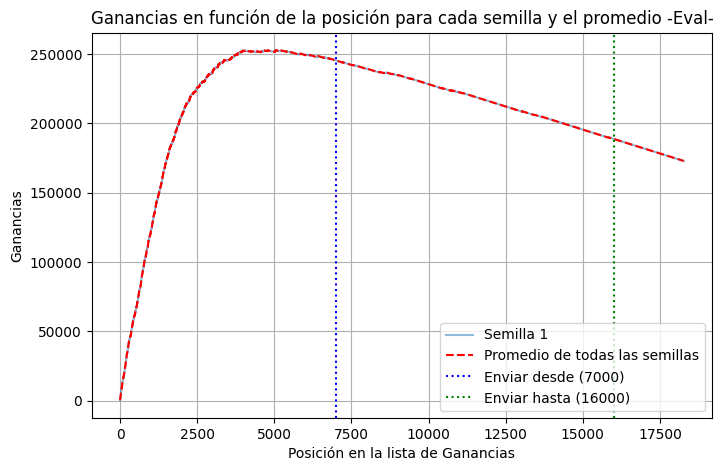

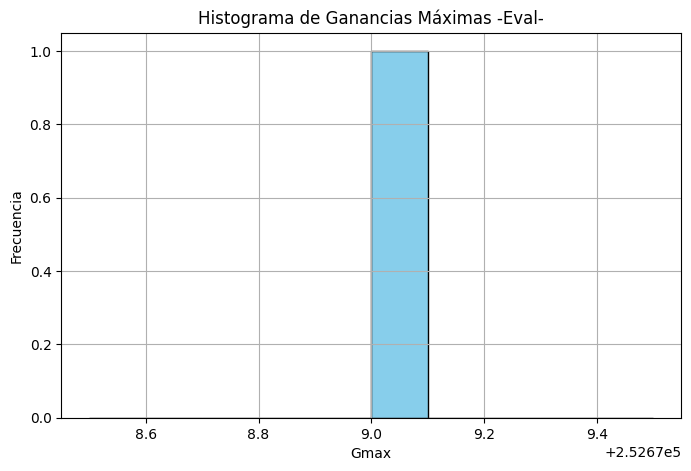

In [55]:
graficar_ganancias_envios(resultados_semillas, "Eval", enviar_desde, enviar_hasta)
histograma_ganancias(resultados_semillas, "Eval")

## Para Kaggle



In [56]:
def enviar_kaggle(probabilidades_promediadas, X_test):
  # Cargo el kaggle.json para poder conectarme
  # Mueve kaggle.json al directorio correcto
 if not vm:
      os.makedirs('/root/.kaggle', exist_ok=True)
      shutil.copy(f'{kaggle_json_path}/kaggle.json', '/root/.kaggle/kaggle.json')
      os.chmod('/root/.kaggle/kaggle.json', 600)
  # Obtengo el orden de prioridad para el envío
    
 idx_deseables=np.argsort(probabilidades_promediadas)[::-1]
    # ------------------------------------------------------------------
  # Los topes de envíos se determinaron al hacer la curva en eval
 enviar_desde=12000
 enviar_hasta=12000
 cant_envios=1
 for envios in np.linspace(enviar_desde, enviar_hasta, cant_envios, dtype=int):
      print (f"Enviando: {envios}")
      # Notar que idx_deseables tiene índices de y_pred (de 0 al máximo de línes de y_pred)

      # los primeros envíos irán con predicción 1 y el resto 0
      # idx_deseables contiene los índices de y_pred (no los originales!!) cuyas predicciones tienen los mejores valores, en orden desdendente
      # guardo en elegidos los índices de los datos correspondientes a los primeros :envios en idx
      elegidos=X_test.index[idx_deseables[:envios]]

      # Creo clientes_kaggle sólo con el número de cliente de  X_test
      clientes_kaggle=X_test.loc[:, ['numero_de_cliente']].copy()
      clientes_kaggle['Predicted']=0    #default
      clientes_kaggle.loc[elegidos, 'Predicted'] = 1   # marco los "enviados"

      if clientes_kaggle.shape != ( 165442, 2):
        raise ValueError(f"El DataFrame 'clientes_enviados' no tiene la forma esperada. Forma actual: {clientes_kaggle.shape}")
      else:
        print("La forma de 'clientes_enviados' es correcta.")

      # elijo el nombre para el archivo enviar, para llevar control
      # un mensaje para registrar
      # y me grabo el archivo que mando para tener control local

      # Voy a mandar con un mensaje que incluya los parámetros usados y la cantidad de envíos
      mensaje=f"lgbm aumentada semillero {best_params} {envios}"
      # # Me gusta guardar los envíos que hago
      archivo=f'{prefijo_envio}-exp{experimento}-{envios}-{str(version).zfill(3)}.csv'
      import os 
      path_archivo=os.path.join(dataset_path,archivo)
      clientes_kaggle.to_csv(path_archivo, index=False)

      # Envío a la competencia
      competencia="dm-ey-f-2024-segunda"
      !kaggle competitions submit -c {competencia} -f '{path_archivo}' -m '{mensaje}'

 params_str = str(best_params)

 # Eliminar llaves {}, apóstrofes ' y dos puntos :
 params_str = params_str.replace('{', '').replace('}', '').replace("'", '').replace(':', '').replace(",",'')
 print (params_str)

 print (clientes_kaggle)



In [57]:
reentrenar_con_mes_eval=False
if reentrenar_con_mes_eval:
    mes_hasta_para_entrenar=mes_eval
else:
    mes_hasta_para_entrenar=mes_train_hasta
if mes_test > 0:
    print (f"Usando entrenamiento con los meses {mes_train_desde} a {mes_hasta_para_entrenar}")
    # notar que se entrena hasta el mes eval!!!
    (X_train, y_train, w_train, X_test, y_test, w_test) = train_test(data, mes_train_desde, mes_hasta_para_entrenar, mes_test)
    contabilizar(X_train, 'datos de entrenamiento')
    contabilizar(X_test, 'datos de evaluación')


   # Entrenar en train y predecir en test
    if vm:
        semis=[semillas[0]]
    else:
        semis=semillas
    probabilidades_totales=entrenar_con_semillero(X_train, y_train, w_train, best_params, semis, X_test)
          # Promediar las probabilidades predichas por todos los modelos
    probabilidades_promediadas = np.mean(probabilidades_totales, axis=0)
    

Usando entrenamiento con los meses 202101 a 202105
Separando train y test
Armando X_train
Armando X_test
listo

Contabilización de la base datos de entrenamiento


Shape: (90251, 1366)

Variables: 1366
Variables tree: 320

Filas por mes: 
foto_mes
202104    18363
202105    18352
202103    18169
202102    17886
202101    17481
Name: count, dtype: int64


Contabilización de la base datos de evaluación


Shape: (165442, 1366)

Variables: 1366
Variables tree: 320

Filas por mes: 
foto_mes
202108    165442
Name: count, dtype: int64

1/1 Entrenando modelo con semilla 101


In [59]:
y_pred_eval=model.predict(X_eval)

In [60]:

np.sort(y_pred_eval)[::-1]

array([9.99990899e-01, 9.99986443e-01, 9.99983491e-01, ...,
       7.53964269e-09, 7.34771647e-09, 7.10448216e-09])

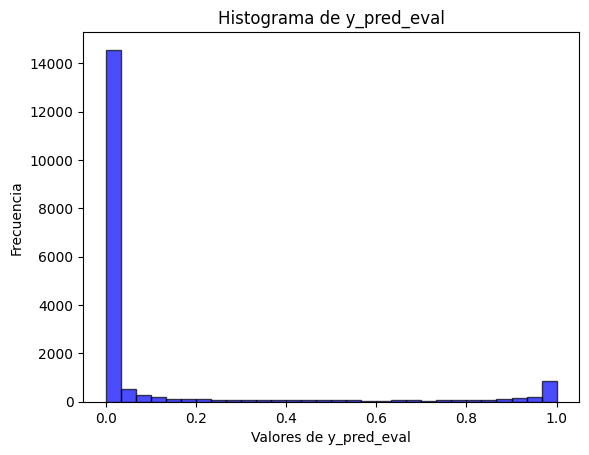

In [61]:
# Suponiendo que y_pred_eval es un array o lista
plt.hist(y_pred_eval, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histograma de y_pred_eval')
plt.xlabel('Valores de y_pred_eval')
plt.ylabel('Frecuencia')
plt.show()

In [62]:
y_pred_test=model.predict(X_test)

In [63]:
np.sort(y_pred_test)[::-1]
#y_pred_test

array([9.99998376e-01, 9.99991594e-01, 9.99990174e-01, ...,
       5.51359952e-08, 4.74410322e-08, 4.08598102e-08])

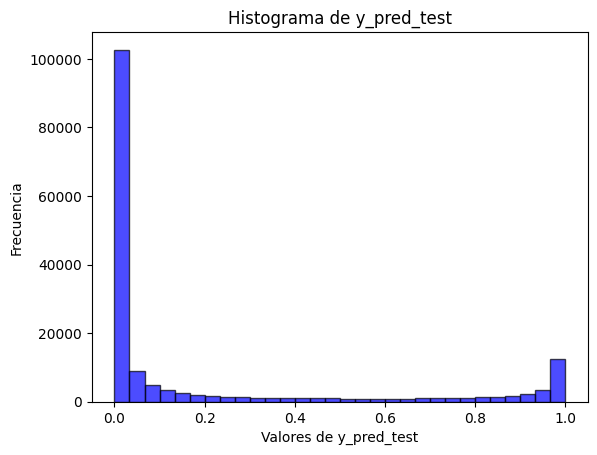

In [64]:
# Suponiendo que y_pred_eval es un array o lista
plt.hist(y_pred_test, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histograma de y_pred_test')
plt.xlabel('Valores de y_pred_test')
plt.ylabel('Frecuencia')
plt.show()

In [69]:
  # Obtengo el orden de prioridad para el envío
    
idx_deseables=np.argsort(y_pred_test)[::-1]
idx_deseables

array([154197,  81622,  45654, ...,  33766,  19339,  74969])

In [70]:
y_pred_test[idx_deseables]

array([9.99998376e-01, 9.99991594e-01, 9.99990174e-01, ...,
       5.51359952e-08, 4.74410322e-08, 4.08598102e-08])

In [71]:
envios=12000
print (f"Enviando: {envios}")
# Notar que idx_deseables tiene índices de y_pred (de 0 al máximo de línes de y_pred)

# los primeros envíos irán con predicción 1 y el resto 0
# idx_deseables contiene los índices de y_pred (no los originales!!) cuyas predicciones tienen los mejores valores, en orden desdendente
idx_deseables=np.argsort(y_pred_test)[::-1]
# guardo en elegidos los índices de los datos correspondientes a los primeros :envios en idx
elegidos=X_test.index[idx_deseables[:envios]]

# Creo clientes_kaggle sólo con el número de cliente de  X_test
clientes_kaggle=X_test.loc[:, ['numero_de_cliente']].copy()
clientes_kaggle['Predicted']=0    #default
clientes_kaggle.loc[elegidos, 'Predicted'] = 1   # marco los "enviados"

if clientes_kaggle.shape != ( 165442, 2):
    raise ValueError(f"El DataFrame 'clientes_enviados' no tiene la forma esperada. Forma actual: {clientes_kaggle.shape}")
else:
    print("La forma de 'clientes_enviados' es correcta.")

# elijo el nombre para el archivo enviar, para llevar control
# un mensaje para registrar
# y me grabo el archivo que mando para tener control local

# Voy a mandar con un mensaje que incluya los parámetros usados y la cantidad de envíos
mensaje=f"lgbm aumentada semillero {best_params} {envios}"
# # Me gusta guardar los envíos que hago
archivo=f'{prefijo_envio}-{envios}-{str(version).zfill(3)}.csv'
import os
path_archivo=os.path.join(dataset_path,archivo)
clientes_kaggle.to_csv(path_archivo, index=False)

# Envío a la competencia
competencia="dm-ey-f-2024-segunda"
!kaggle competitions submit -c {competencia} -f '{path_archivo}' -m '{mensaje}'




Enviando: 12000
La forma de 'clientes_enviados' es correcta.


In [72]:
#pd.DataFrame(X_test).to_csv(os.path.join(dataset_path, "X_test.csv"))

In [73]:
clientes_kaggle.loc[clientes_kaggle['Predicted']==1, 'numero_de_cliente']

41198      249221468
113276     249228180
45703      249236857
113285     249283313
320451     249286746
             ...    
71218     1602580999
352156    1602786354
270631    1603402811
5512      1603451599
94641     1603775178
Name: numero_de_cliente, Length: 12000, dtype: int64

In [74]:
#pd.DataFrame(X_test).to_csv(os.path.join(dataset_path, "X_test.csv"))

In [75]:
idx_deseables

array([154197,  81622,  45654, ...,  33766,  19339,  74969])

In [76]:
elegidos

Index([ 14118, 207922, 345955, 252871, 107817,   4029, 256583,  56741, 217035,
        93280,
       ...
       158042,  70050, 293683,  20378, 291176,  48223,  60928, 113994, 181713,
       110741],
      dtype='int64', length=12000)

In [77]:
data.iloc[221620]

numero_de_cliente    304052053
foto_mes                202108
active_quarter               1
cliente_vip                  0
internet                     0
                       ...    
tree_19_leaf_11            0.0
tree_19_leaf_12            0.0
tree_19_leaf_13            1.0
tree_19_leaf_14            0.0
tree_19_leaf_15            0.0
Name: 278385, Length: 1370, dtype: object

In [100]:
reentrenar_con_mes_eval=False
if reentrenar_con_mes_eval:
    mes_hasta_para_entrenar=mes_eval
else:
    mes_hasta_para_entrenar=mes_train_hasta
if mes_test > 0:
    print (f"Usando entrenamiento con los meses {mes_train_desde} a {mes_hasta_para_entrenar}")
    # notar que se entrena hasta el mes eval!!!
    (X_train, y_train, w_train, X_test, y_test, w_test) = train_test(data, mes_train_desde, mes_hasta_para_entrenar, mes_test)
    contabilizar(X_train, 'datos de entrenamiento')
    contabilizar(X_test, 'datos de evaluación')


   # Entrenar en train y predecir en test
    if vm:
        semis=[semillas[0]]
    else:
        semis=semillas
     
    probabilidades_totales=entrenar_con_semillero(X_train, y_train, w_train, best_params, semis, X_test)
          # Promediar las probabilidades predichas por todos los modelos
    probabilidades_promediadas = np.mean(probabilidades_totales, axis=0)

    enviar_kaggle(probabilidades_promediadas, X_test)


SyntaxError: invalid syntax (462429069.py, line 23)